<a href="https://colab.research.google.com/github/veeransr/ML-and-Deep-learning-practice-with-python/blob/master/pipiline_in_pyspark_and_merging_files_n_indexing_and_constructing_parquet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is designed to run in a IBM Watson Studio default runtime (NOT the Watson Studio Apache Spark Runtime as the default runtime with 1 vCPU is free of charge). Therefore, we install Apache Spark in local mode for test purposes only. Please don't use it in production.

In case you are facing issues, please read the following two documents first:

https://github.com/IBM/skillsnetwork/wiki/Environment-Setup

https://github.com/IBM/skillsnetwork/wiki/FAQ

Then, please feel free to ask:

https://coursera.org/learn/machine-learning-big-data-apache-spark/discussions/all

Please make sure to follow the guidelines before asking a question:

https://github.com/IBM/skillsnetwork/wiki/FAQ#im-feeling-lost-and-confused-please-help-me


If running outside Watson Studio, this should work as well. In case you are running in an Apache Spark context outside Watson Studio, please remove the Apache Spark setup in the first notebook cells.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

In [0]:
!pip install pyspark

     |████████████████████████████████| 217.8MB 63kB/s 
     |████████████████████████████████| 204kB 44.5MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=ac583cd88d3272c0a1563db223b4be2a13a31c7087f69ef847cb3adeb4ef81c2
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [0]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.util import MLUtils
import numpy as np
from pyspark.ml.feature import StandardScaler
import pyspark.sql.functions as f
import pyspark.sql.types
import pandas as pd
from pyspark.sql import Row
spark = SparkSession.builder.getOrCreate()
sc = SparkContext.getOrCreate()
from pyspark.ml.feature import VectorAssembler

Welcome to exercise one of week three of “Apache Spark for Scalable Machine Learning on BigData”. In this exercise we’ll use the HMP dataset again and perform some basic operations using Apache SparkML Pipeline components.

Let’s create our DataFrame again:


In [0]:
# delete files from previous runs
!rm -f hmp.parquet*

# download the file containing the data in PARQUET format
!wget https://github.com/IBM/coursera/raw/master/hmp.parquet
x = pd.read_parquet('hmp.parquet')
# create a dataframe out of it
#df = spark.read('x')
spark_df = spark.createDataFrame(x)
# register a corresponding query table


--2020-05-27 16:53:37--  https://github.com/IBM/coursera/raw/master/hmp.parquet
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/raw/master/hmp.parquet [following]
--2020-05-27 16:53:37--  https://github.com/IBM/skillsnetwork/raw/master/hmp.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/hmp.parquet [following]
--2020-05-27 16:53:37--  https://raw.githubusercontent.com/IBM/skillsnetwork/master/hmp.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932997 (91

In [0]:
spark_df.head()

Row(x=22, y=49, z=35, source='Accelerometer-2011-04-11-13-28-18-brush_teeth-f1.txt', class='Brush_teeth')

Given below is the feature engineering pipeline from the lecture. Please add a feature column called “features_minmax” using the MinMaxScaler.

More information can be found here:
http://spark.apache.org/docs/latest/ml-features.html#minmaxscaler

In [0]:
spark_df.describe().show()

+-------+------------------+-----------------+-----------------+--------------------+-----------+
|summary|                 x|                y|                z|              source|      class|
+-------+------------------+-----------------+-----------------+--------------------+-----------+
|  count|            446529|           446529|           446529|              446529|     446529|
|   mean|24.671555486877672|38.21949078335338|41.83984242904716|                null|       null|
| stddev|12.157593006180992| 7.69068848723174| 8.30343589941348|                null|       null|
|    min|                 0|                0|                0|Accelerometer-201...|Brush_teeth|
|    max|                63|               63|               63|Accelerometer-201...|       Walk|
+-------+------------------+-----------------+-----------------+--------------------+-----------+



In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Normalizer, MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

In [0]:
indexer = StringIndexer(inputCol="class", outputCol="classIndex")
encoder = OneHotEncoder(inputCol="classIndex", outputCol="categoryVec")
vectorAssembler = VectorAssembler(inputCols=["x","y","z"],
                                  outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)

minmaxscaler = MinMaxScaler(inputCol="features_norm", outputCol="scaledFeatures")

In [0]:
pipeline = Pipeline(stages=[indexer, encoder, vectorAssembler, normalizer, minmaxscaler])
model = pipeline.fit(spark_df)
prediction = model.transform(spark_df)
prediction.show()

+---+---+---+--------------------+-----------+----------+--------------+----------------+--------------------+--------------------+
|  x|  y|  z|              source|      class|classIndex|   categoryVec|        features|       features_norm|      scaledFeatures|
+---+---+---+--------------------+-----------+----------+--------------+----------------+--------------------+--------------------+
| 22| 49| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,49.0,35.0]|[0.20754716981132...|[0.26684636118598...|
| 22| 49| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,49.0,35.0]|[0.20754716981132...|[0.26684636118598...|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,52.0,35.0]|[0.20183486238532...|[0.25950196592398...|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,52.0,35.0]|[0.20183486238532...|[0.25950196592398...|
| 21| 52| 34|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[21.

The difference between a transformer and an estimator is state. A transformer is stateless whereas an estimator keeps state. Therefore “VectorAsselmbler” is a transformer since it only need to read row by row. Normalizer, on the other hand need to compute statistics on the dataset before, therefore it is an estimator. An estimator has an additional “fit” function. “OneHotEncoder” has been deprecated in Spark 2.3, therefore please change the code below to use the OneHotEstimator instead of the “OneHotEncoder”.

More information can be found here:
http://spark.apache.org/docs/latest/ml-features.html#onehotencoderestimator





In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Normalizer, MinMaxScaler, OneHotEncoderEstimator
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

In [0]:
indexer = StringIndexer(inputCol="class", outputCol="classIndex")
encoder = OneHotEncoderEstimator (inputCols=["classIndex"], outputCols=["categoryVec"])

In [0]:
vectorAssembler = VectorAssembler(inputCols=["x","y","z"],
                                  outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)


pipeline = Pipeline(stages=[indexer, encoder, vectorAssembler, normalizer])
model = pipeline.fit(spark_df)
prediction1 = model.transform(spark_df)
prediction.show()

+---+---+---+--------------------+-----------+----------+--------------+----------------+--------------------+--------------------+
|  x|  y|  z|              source|      class|classIndex|   categoryVec|        features|       features_norm|      scaledFeatures|
+---+---+---+--------------------+-----------+----------+--------------+----------------+--------------------+--------------------+
| 22| 49| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,49.0,35.0]|[0.20754716981132...|[0.26684636118598...|
| 22| 49| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,49.0,35.0]|[0.20754716981132...|[0.26684636118598...|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,52.0,35.0]|[0.20183486238532...|[0.25950196592398...|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[22.0,52.0,35.0]|[0.20183486238532...|[0.25950196592398...|
| 21| 52| 34|Accelerometer-201...|Brush_teeth|       6.0|(13,[6],[1.0])|[21.

In [0]:
pca = PCA(k=3, inputCol = 'scaledFeatures', outputCol="pcaFeatures")
model = pca.fit(prediction)
transformed_feature = model.transform(prediction)

In [0]:
transformed_feature.select('pcaFeatures').rdd.map(lambda x: Row(pcaFeatures = str([x for x in list(np.round(x[0].\
                                                    toArray(),4))]))).toDF().show(truncate = False)

+-------------------------+
|pcaFeatures              |
+-------------------------+
|[0.1096, 0.0034, 0.6742] |
|[0.1096, 0.0034, 0.6742] |
|[0.1249, -0.0102, 0.6742]|
|[0.1249, -0.0102, 0.6742]|
|[0.1364, -0.0153, 0.6742]|
|[0.1208, -0.0149, 0.6742]|
|[0.1361, 0.0071, 0.6742] |
|[0.1258, -0.0193, 0.6742]|
|[0.1156, -0.0104, 0.6742]|
|[0.1199, -0.0057, 0.6742]|
|[0.1323, -0.0202, 0.6742]|
|[0.1371, -0.0022, 0.6742]|
|[0.122, -0.0111, 0.6742] |
|[0.122, -0.0111, 0.6742] |
|[0.1411, 0.0024, 0.6742] |
|[0.1545, 0.0113, 0.6742] |
|[0.138, 0.0118, 0.6742]  |
|[0.1969, 0.0005, 0.6742] |
|[0.1679, 0.0061, 0.6742] |
|[0.1671, -0.0176, 0.6742]|
+-------------------------+
only showing top 20 rows



In [0]:
transformed_feature .count()

446529

In [0]:
rdd = transformed_feature.rdd.sample(False,0.01)

In [0]:
x = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[0]).collect()

In [0]:
y = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[1]).collect()

In [0]:
z = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[2]).collect()

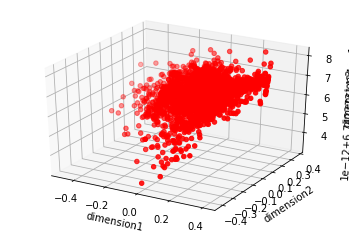

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')




ax.scatter(x,y,z, c='r', marker='o')

ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')

plt.show()

Sampled with 0.2

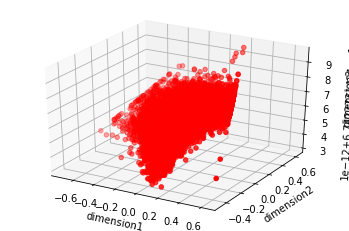

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')




ax.scatter(x,y,z, c='r', marker='o')

ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')

plt.show()

The below is sampled with 0.8

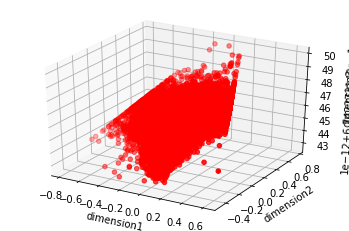

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')




ax.scatter(x,y,z, c='r', marker='o')

ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')

plt.show()

In [0]:
!git clone htpps://github.com/wchill/HMP_Dataset.git

Cloning into 'HMP_Dataset'...
fatal: Unable to find remote helper for 'htpps'


In [0]:
!git clone https://github.com/wchill/HMP_Dataset.git

Cloning into 'HMP_Dataset'...
remote: Enumerating objects: 865, done.
remote: Total 865 (delta 0), reused 0 (delta 0), pack-reused 865
Receiving objects: 100% (865/865), 1010.96 KiB | 11.75 MiB/s, done.


In [0]:
!ls HMP_Dataset

Brush_teeth	Drink_glass  Getup_bed	  Pour_water	 Use_telephone
Climb_stairs	Eat_meat     impdata.py   README.txt	 Walk
Comb_hair	Eat_soup     Liedown_bed  Sitdown_chair
Descend_stairs	final.py     MANUAL.txt   Standup_chair


In [0]:
!ls HMP_Dataset/Brush_teeth

Accelerometer-2011-04-11-13-28-18-brush_teeth-f1.txt
Accelerometer-2011-04-11-13-29-54-brush_teeth-f1.txt
Accelerometer-2011-05-30-08-35-11-brush_teeth-f1.txt
Accelerometer-2011-05-30-09-36-50-brush_teeth-f1.txt
Accelerometer-2011-05-30-10-34-16-brush_teeth-m1.txt
Accelerometer-2011-05-30-21-10-57-brush_teeth-f1.txt
Accelerometer-2011-05-30-21-55-04-brush_teeth-m2.txt
Accelerometer-2011-05-31-15-16-47-brush_teeth-f1.txt
Accelerometer-2011-06-02-10-42-22-brush_teeth-f1.txt
Accelerometer-2011-06-02-10-45-50-brush_teeth-f1.txt
Accelerometer-2011-06-06-10-45-27-brush_teeth-f1.txt
Accelerometer-2011-06-06-10-48-05-brush_teeth-f1.txt


In [0]:
from pyspark.sql.types import StructType, StructField, IntegerType
schema = StructType([StructField('x', IntegerType(), True),
                     StructField('y', IntegerType(), True), 
                     StructField('z', IntegerType(), True)])

In [0]:
import os
!pwd


/content


In [0]:
!ls '/content/HMP_Dataset/'

Brush_teeth	Drink_glass  Getup_bed	  Pour_water	 Use_telephone
Climb_stairs	Eat_meat     impdata.py   README.txt	 Walk
Comb_hair	Eat_soup     Liedown_bed  Sitdown_chair
Descend_stairs	final.py     MANUAL.txt   Standup_chair


In [0]:
file_list = os.listdir ('/content/HMP_Dataset')
print(file_list)

['MANUAL.txt', 'Descend_stairs', 'Brush_teeth', 'Getup_bed', 'Pour_water', 'Climb_stairs', 'Use_telephone', '.git', 'Eat_meat', 'Drink_glass', 'Standup_chair', 'Sitdown_chair', 'impdata.py', '.idea', 'Liedown_bed', 'Eat_soup', 'final.py', 'Walk', 'Comb_hair', 'README.txt']


In [0]:
file_list_filtered = [s for s in file_list if '_' in s]
file_list_filtered

['Descend_stairs',
 'Brush_teeth',
 'Getup_bed',
 'Pour_water',
 'Climb_stairs',
 'Use_telephone',
 'Eat_meat',
 'Drink_glass',
 'Standup_chair',
 'Sitdown_chair',
 'Liedown_bed',
 'Eat_soup',
 'Comb_hair']

In [0]:
df1 = None
from pyspark.sql.functions import lit
for category in file_list_filtered:
  data_file = os.listdir ('HMP_Dataset/'+ category)
  for data in data_file:
    print(data)
    temp_df = spark.read.option ('header', 'false').option ('delimiter', ' ').csv('/content/HMP_Dataset/'+ category + '/'+ data, schema = schema)
    temp_df = temp_df.withColumn ('class', lit(category))
    temp_df = temp_df.withColumn ('source', lit(data))
    if df1 == None:
      df1 = temp_df
    else:
        df1 = df1.union(temp_df)

Accelerometer-2011-05-30-10-24-51-descend_stairs-m1.txt
Accelerometer-2011-06-06-11-01-54-descend_stairs-f1.txt
Accelerometer-2011-05-30-21-09-46-descend_stairs-f1.txt
Accelerometer-2011-06-06-10-59-38-descend_stairs-f1.txt
Accelerometer-2011-05-30-21-53-35-descend_stairs-m2.txt
Accelerometer-2011-06-06-10-56-55-descend_stairs-f1.txt
Accelerometer-2011-05-31-16-28-22-descend_stairs-f1.txt
Accelerometer-2011-05-30-08-20-55-descend_stairs-f1.txt
Accelerometer-2011-05-30-09-29-15-descend_stairs-f1.txt
Accelerometer-2011-04-05-18-26-06-descend_stairs-f1.txt
Accelerometer-2011-03-24-10-24-02-descend_stairs-f1.txt
Accelerometer-2011-06-06-10-56-23-descend_stairs-f1.txt
Accelerometer-2011-03-29-16-17-50-descend_stairs-f1.txt
Accelerometer-2011-04-11-11-51-27-descend_stairs-f1.txt
Accelerometer-2011-03-29-16-18-14-descend_stairs-f1.txt
Accelerometer-2011-06-02-10-36-42-descend_stairs-f1.txt
Accelerometer-2011-06-06-10-58-40-descend_stairs-f1.txt
Accelerometer-2011-05-31-15-15-48-descend_stairs

In [0]:
df1.show()

+---+---+---+--------------+--------------------+
|  x|  y|  z|         class|              source|
+---+---+---+--------------+--------------------+
| 12| 38| 35|Descend_stairs|Accelerometer-201...|
| 12| 38| 35|Descend_stairs|Accelerometer-201...|
| 13| 40| 35|Descend_stairs|Accelerometer-201...|
| 13| 40| 36|Descend_stairs|Accelerometer-201...|
| 12| 40| 34|Descend_stairs|Accelerometer-201...|
| 14| 39| 35|Descend_stairs|Accelerometer-201...|
| 13| 40| 35|Descend_stairs|Accelerometer-201...|
| 12| 39| 35|Descend_stairs|Accelerometer-201...|
| 12| 40| 35|Descend_stairs|Accelerometer-201...|
| 12| 40| 35|Descend_stairs|Accelerometer-201...|
| 13| 37| 37|Descend_stairs|Accelerometer-201...|
| 12| 40| 35|Descend_stairs|Accelerometer-201...|
| 13| 39| 36|Descend_stairs|Accelerometer-201...|
| 13| 40| 36|Descend_stairs|Accelerometer-201...|
| 13| 39| 37|Descend_stairs|Accelerometer-201...|
| 12| 41| 36|Descend_stairs|Accelerometer-201...|
| 13| 41| 36|Descend_stairs|Accelerometer-201...|


In [0]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer (inputCol= 'class', outputCol= 'calssIndex')
df1_indexed = indexer.fit (df1).transform (df1)
df1_indexed.show()

+---+---+---+--------------+--------------------+----------+
|  x|  y|  z|         class|              source|calssIndex|
+---+---+---+--------------+--------------------+----------+
| 12| 38| 35|Descend_stairs|Accelerometer-201...|       9.0|
| 12| 38| 35|Descend_stairs|Accelerometer-201...|       9.0|
| 13| 40| 35|Descend_stairs|Accelerometer-201...|       9.0|
| 13| 40| 36|Descend_stairs|Accelerometer-201...|       9.0|
| 12| 40| 34|Descend_stairs|Accelerometer-201...|       9.0|
| 14| 39| 35|Descend_stairs|Accelerometer-201...|       9.0|
| 13| 40| 35|Descend_stairs|Accelerometer-201...|       9.0|
| 12| 39| 35|Descend_stairs|Accelerometer-201...|       9.0|
| 12| 40| 35|Descend_stairs|Accelerometer-201...|       9.0|
| 12| 40| 35|Descend_stairs|Accelerometer-201...|       9.0|
| 13| 37| 37|Descend_stairs|Accelerometer-201...|       9.0|
| 12| 40| 35|Descend_stairs|Accelerometer-201...|       9.0|
| 13| 39| 36|Descend_stairs|Accelerometer-201...|       9.0|
| 13| 40| 36|Descend_sta